# START!

In [1]:
import os
import time
import copy
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from PIL import Image

import torchvision
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

In [2]:
torch.__version__, torchvision.__version__

('1.2.0', '0.4.0')

In [3]:
torch.rand(1).cuda()

tensor([0.4786], device='cuda:0')

In [4]:
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
!nvidia-smi

Wed Mar 17 14:23:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.129      Driver Version: 410.129      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  Off  | 00000000:01:00.0  On |                  N/A |
| 42%   71C    P2    84W / 250W |   2035MiB / 12212MiB |      3%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [6]:
class ToTensor(object):
    """Convert ndarray in sample to Tensors."""
    def __call__(self, sample):
        return torch.Tensor(sample)

class TrailersDataset(Dataset):
    """Anime trailers dataset."""

    def __init__(self, image_paths, labels_path, image_transform=None, label_transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image_transform = image_transform
        self.label_transform = label_transform

        npz = np.load(labels_path)
        self.labels = npz['labels']
        self.genres = npz['genres']
        self.index = {str(npz['anime_ids'][i]) : i for i in range(len(npz['anime_ids']))}

        self.images = np.array([(os.path.split(os.path.split(x)[0])[1], x) for x in image_paths])
        self.images = self.images[[x in self.index.keys() for x in self.images[:,0]]]

        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image = Image.open(self.images[idx,1]).convert('RGB')
        id = self.images[idx,0]
        label = self.labels[self.index[id]]

        if self.image_transform:
            image = self.image_transform(image)
            
        if self.label_transform:
            label = self.label_transform(label)

        sample = (image, label)

        return sample

In [7]:
image_paths = glob('../data/frames_main/*/*.jpg', recursive=True) + \
              glob('../data/frames_new/*/*.jpg', recursive=True)
image_splits = {x[0]: x[1] for x in zip((['train', 'val']), train_test_split(image_paths, test_size=0.3, random_state=0))}

In [8]:
image_transform = transforms.Compose([
        transforms.Resize((360,640)),#transforms.Resize((720,1280)),
        transforms.RandomCrop((288,512)),#transforms.RandomCrop((576,1024)),
        transforms.ToTensor(),
        ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

label_transform = transforms.Compose([
        ToTensor()
    ])

image_datasets = {x: TrailersDataset(image_splits[x],'../outputs/labels.npz',
                                     image_transform, label_transform)
                  for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, 
                                              shuffle=True, num_workers=5, pin_memory=True)
               for x in ['train', 'val']}

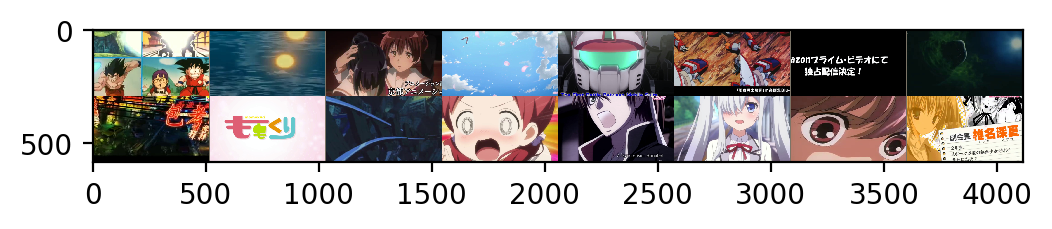

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    plt.figure(dpi=200)
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)


imshow(out)

In [10]:
[image_datasets['train'].genres[i] for i in range(len(image_datasets['train'].genres)) if classes[0][i] == True]

['Action',
 'Adventure',
 'Comedy',
 'Fantasy',
 'Sci-Fi',
 'Shounen',
 'Super Power']

In [11]:
n_classes = len(image_datasets['train'].genres)

model = torch.hub.load('pytorch/vision:v0.4.0', 'resnet50', pretrained=True)
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=n_classes)

model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
epoch = 0
losses = {'train':[], 'val':[]}
accs   = {'train':[], 'val':[]}

LOAD_PATH = '../outputs/state_classification.pth'
if os.path.isfile(LOAD_PATH):
    checkpoint = torch.load(LOAD_PATH)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    epoch = checkpoint['epoch']+1
    losses = checkpoint['losses']
    accs = checkpoint['accs']
    print("Loaded Checkpoint")
    

print(model.eval())

Using cache found in /home/kellermartins/.cache/torch/hub/pytorch_vision_v0.4.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

23592041

In [13]:
def train_model(model, criterion, optimizer, num_epochs=8, epoch=0, 
                losses={'train':[], 'val':[]}, accs={'train':[], 'val':[]}):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float("Inf")
    best_acc  = 0
    num_epochs = epoch+num_epochs
    
    minibatch_progress = tqdm(total=0, leave=True)

    for epoch in tqdm(range(epoch, num_epochs), leave=True):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_acc = 0.0
            minibatch_progress.reset(len(dataloaders[phase]))

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                minibatch_progress.update()
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    preds = torch.sigmoid(outputs).data > 0.5
                    preds = preds.to(torch.float32)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                lss = loss.item()
                acc = accuracy_score(labels.to("cpu").to(torch.int).numpy(),
                                      preds.to("cpu").to(torch.int).numpy())
                
                running_loss += lss * inputs.size(0)
                running_acc  += acc * inputs.size(0)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_acc / dataset_sizes[phase]
            
            losses[phase].append(epoch_loss)
            accs[phase].append(epoch_acc)
            print('{} Acc: {:.4f} Loss: {:.4f}'.format(
                phase, epoch_acc, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'losses': losses,
                    }, '../outputs/state_classification_training.pth')
        
        plt.plot(losses['train'])
        plt.plot(losses['val'])
        plt.show()
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f} acc: {:4f}'.format(best_loss, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return epoch, model, losses, accs

In [ ]:
epoch, model, losses, accs = train_model(model, criterion, optimizer, num_epochs, epoch, losses)

0it [00:00, ?it/s]
  0%|          | 0/10902 [00:00<?, ?it/s]

Epoch 0/19
----------


 21%|██        | 2254/10902 [16:05<1:01:44,  2.33it/s]

In [ ]:
plt.plot(losses['train'])
plt.plot(losses['val'])

In [ ]:
plt.plot(accs['train'])
plt.plot(accs['val'])